# Object localization - Bounding Box

---



## The Oxford-IIIT Pet Dataset
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

Link to dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

Firstly, let's select TensorFlow version 2.x in colab

In [24]:
import numpy as np
import csv
import ntpath



import tensorflow
tensorflow.__version__



'2.4.1'

In [11]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

As we are using google colab, we need to mount the google drive to load the data file

In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Add path to the folder where your dataset files are

In [12]:
project_path = './'

Let's load the dataset now

In [14]:
images_zip_path = project_path + "data/images.zip"

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall("./data")

In [15]:
DATASET_FOLDER = "./data/images/"
TRAIN_CSV = project_path + "data/train.csv"
VALIDATION_CSV = project_path + "data/validation.csv"

### Get training data

In [26]:
import numpy as np
import csv

IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96

with open(TRAIN_CSV, "r") as f:
  
  y_train = np.zeros((sum(1 for line in f), 4))
  X_train = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      row[i+1] = int(r)
    path, image_height, image_width, x0, y0, x1, y1, _, _ = row       # Read image, its dimensions, BBox coords
    path = "./data/" + path.split('/')[-2] + "/" + path.split('/')[-1]
    y_train[index, 0] = x0 * IMAGE_SIZE / image_width                 # Normalize bounding box by image size
    y_train[index, 1] = y0 * IMAGE_SIZE / image_height                # Normalize bounding box by image size
    y_train[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width          # Normalize bounding box by image size
    y_train[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height         # Normalize bounding box by image size

    X_train.append(path)                                              # All training images in this list

In [27]:
X_train[:5]

['./data/images/Abyssinian_1.jpg',
 './data/images/Abyssinian_10.jpg',
 './data/images/Abyssinian_100.jpg',
 './data/images/Abyssinian_101.jpg',
 './data/images/Abyssinian_102.jpg']

In [28]:
y_train[0]

array([36.90666667, 23.04      , 19.62666667, 27.52      ])

In [81]:
y_train.shape

(3006, 4)

### Let's check how does the data look like

Fetching coordinates details

In [31]:
import cv2
# Pick a random image to check how it looks
filename = X_train[97]
unscaled = cv2.imread(filename)
region = y_train[97]
image_height, image_width, _ = unscaled.shape
print(unscaled.shape)
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

(375, 500, 3)


Now, let's plot the image and the bounding box on top of it

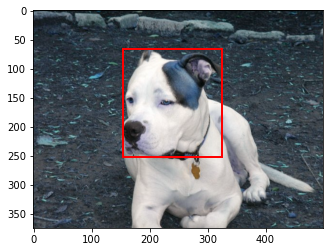

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Back to data preparation

In [33]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(X_train):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [34]:
X_train = np.array(X_train)

In [35]:
X_train.shape

(3006, 128, 128, 3)

In [36]:
y_train

array([[36.90666667, 23.04      , 19.62666667, 27.52      ],
       [24.576     , 26.88      , 73.728     , 47.616     ],
       [49.05583756, 18.176     , 59.77664975, 50.176     ],
       ...,
       [24.064     , 13.79640719, 72.704     , 86.99401198],
       [70.144     , 32.19161677, 32.768     , 47.13772455],
       [24.591133  , 15.872     , 71.56650246, 49.664     ]])

In [37]:
y_train.shape

(3006, 4)

In [39]:
with open(VALIDATION_CSV, "r") as f:
  
  y_val = np.zeros((sum(1 for line in f), 4))
  X_val = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      row[i+1] = int(r)
    path, image_height, image_width, x0, y0, x1, y1, _, _ = row     # Read image, its dimensions, BBox coords
    path = "./data/" + path.split('/')[-2] + "/" + path.split('/')[-1]
    y_val[index, 0] = x0 * IMAGE_SIZE / image_width                 # Normalize bounding box by image size
    y_val[index, 1] = y0 * IMAGE_SIZE / image_height                # Normalize bounding box by image size
    y_val[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width          # Normalize bounding box by image size
    y_val[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height         # Normalize bounding box by image size

    X_val.append(path)                                                # All training images in this list

In [40]:
X_val[:5]

['./data/images/Abyssinian_118.jpg',
 './data/images/Abyssinian_124.jpg',
 './data/images/Abyssinian_131.jpg',
 './data/images/Abyssinian_14.jpg',
 './data/images/Abyssinian_15.jpg']

In [41]:
for i, f in enumerate(X_val):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [42]:
X_val = np.array(X_val)

In [43]:
X_val.shape

(680, 128, 128, 3)

In [44]:
y_val

array([[ 0.38438438,  8.704     , 98.4024024 , 68.864     ],
       [33.82582583, 24.064     , 45.74174174, 25.856     ],
       [ 6.99678457, 10.        , 77.78778135, 62.        ],
       ...,
       [52.48      , 36.18133333, 28.928     , 45.056     ],
       [24.832     ,  6.03141361, 49.408     , 76.06282723],
       [11.776     , 19.21921922, 67.84      , 88.02402402]])

In [45]:
y_val.shape

(680, 4)

### Create the model

In [46]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

### Define evaluation metric

In [47]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [59]:
def IoU(y_true, y_pred):
#     print("y_true",y_true[0],y_true[:,0])
#     print("y_pred",y_pred)
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

### Initialize the model and print summary

In [60]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

### Compile the model
- loss: "mean_squared_error"
- metrics: IoU
- optimizer: "adam"

In [61]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

### Training the model

Fit the model to the dataset
- Use early stopping
- fit the model
    - give train data - training features and labels
    - batch size: 32
    - epochs: 10
    - give validation data - testing features and labels

In [62]:
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
94/94 [==============================] - 40s 402ms/step - loss: 560.7079 - IoU: 0.3705 - val_loss: 110.8153 - val_IoU: 0.6244
Epoch 2/10
94/94 [==============================] - 37s 394ms/step - loss: 84.6007 - IoU: 0.6533 - val_loss: 91.8907 - val_IoU: 0.6489
Epoch 3/10
94/94 [==============================] - 37s 398ms/step - loss: 53.8135 - IoU: 0.7109 - val_loss: 87.1011 - val_IoU: 0.6538
Epoch 4/10
94/94 [==============================] - 37s 396ms/step - loss: 38.5139 - IoU: 0.7523 - val_loss: 85.2532 - val_IoU: 0.6598
Epoch 5/10
94/94 [==============================] - 37s 395ms/step - loss: 30.6124 - IoU: 0.7748 - val_loss: 85.4252 - val_IoU: 0.6601
Epoch 6/10
94/94 [==============================] - 37s 396ms/step - loss: 21.5982 - IoU: 0.8068 - val_loss: 86.5156 - val_IoU: 0.6556


### Final loss and accuracy

In [63]:
model.evaluate(X_val, y_val)

22/22 [==============================] - 7s 308ms/step - loss: 86.5156 - IoU: 0.6556


[86.51556396484375, 0.6555591225624084]

### Test the model on an image from test data

In [66]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = './data/images/shiba_inu_163.jpg'

unscaled = cv2.imread(filename) # Original image for display

In [67]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

Size of original input:  (128, 128, 3)
-------------------------------
Size of scaled input:  (128, 128, 3)


In [71]:
region = model.predict(x=np.array([feat_scaled]))# Predict the BBox
region = region[0]

Fetching coordinates details

In [72]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

Now, let's plot the image and the bounding box on top of it

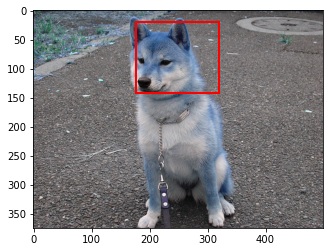

In [73]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [76]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = './data/images/Abyssinian_14.jpg'

unscaled = cv2.imread(filename) # Original image for display

In [77]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [78]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

Fetching coordinates details

In [79]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

Now, let's plot the image and the bounding box on top of it

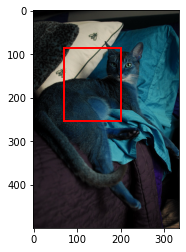

In [80]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()